# Gaussian Process Latent Variable Model

Open processed video sample using OpenCV library:

In [1]:
import numpy as np
import cv2

w,h = 120,90

sample = np.load('data\samplevideo2.npy')
print(sample[0,:])

[ 155.  157.  159. ...,  180.  180.  180.]


Function for displaying one frame:

In [2]:
def show_frame(frame):
    
    mp.imshow(frame.reshape((h,w)),cmap='Greys_r')

Plot the first frame of sample:

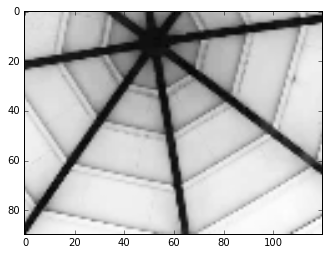

In [3]:
import matplotlib.pyplot as mp

% matplotlib inline
show_frame(sample[0,:])

Initialize all the parameters and normilize given sample:

In [4]:
N = sample.shape[0] # count of samples
D = sample.shape[1] # dimensionality of observed space
Q = 2 # dimensionality of observed space

X = np.zeros((N,Q)) # Initialize the latent variable

#normilizing data:
sample_mean = np.mean(sample)
sample_std = np.std(sample)
sample_norm = (sample - sample_mean)/sample_std # normalization

print(sample_norm[0,:])

[ 0.71639979  0.77022819  0.82405659 ...,  1.38925481  1.38925481
  1.38925481]


Define combined kernel using GPy library:

In [5]:
import GPy

#kernel = GPy.kern.Linear(Q,ARD=True)+GPy.kern.RatQuad(Q,ARD=True)+GPy.kern.MLP(Q,ARD=True)
#kernel = GPy.kern.Linear(Q,ARD=True)+GPy.kern.RBF(Q,ARD=True)+GPy.kern.RatQuad(Q,ARD=True)+GPy.kern.MLP(Q,ARD=True)+GPy.kern.Matern52(Q,ARD=True)
kernel = GPy.kern.RBF(Q,ARD=True)
m = GPy.models.GPLVM(sample_norm, input_dim=Q, kernel=kernel, init='PCA')

Optimization of the model using SCG (Warning! Minimum value for max_iters is 100, for 10000 it takes around 1 hour to perform optimization)

In [6]:
m.optimize(messages=True, optimizer = 'SCG',max_iters=1)

 C:\Users\Maxim\Anaconda3\lib\site-packages\GPy\kern\src\stationary.py:149: RuntimeWarning:overflow encountered in true_divide
 C:\Users\Maxim\Anaconda3\lib\site-packages\GPy\kern\src\stationary.py:121: RuntimeWarning:invalid value encountered in add
 C:\Users\Maxim\Anaconda3\lib\site-packages\GPy\kern\src\rbf.py:37: RuntimeWarning:invalid value encountered in multiply


In [7]:
help(GPy.models.GPLVM)

Help on class GPLVM in module GPy.models.gplvm:

class GPLVM(GPy.core.gp.GP)
 |  Gaussian Process Latent Variable Model
 |  
 |  Method resolution order:
 |      GPLVM
 |      GPy.core.gp.GP
 |      GPy.core.model.Model
 |      paramz.model.Model
 |      paramz.parameterized.Parameterized
 |      GPy.core.parameterization.priorizable.Priorizable
 |      paramz.core.parameter_core.Parameterizable
 |      paramz.core.parameter_core.OptimizationHandlable
 |      paramz.core.constrainable.Constrainable
 |      paramz.core.indexable.Indexable
 |      paramz.core.nameable.Nameable
 |      paramz.core.gradcheckable.Gradcheckable
 |      paramz.core.pickleable.Pickleable
 |      paramz.core.parentable.Parentable
 |      paramz.core.updateable.Updateable
 |      paramz.core.observable.Observable
 |      builtins.object
 |  
 |  Methods defined here:
 |  
 |  __init__(self, Y, input_dim, init='PCA', X=None, kernel=None, name='gplvm')
 |      :param Y: observed data
 |      :type Y: np.ndarray
 |

ValueError: total size of new array must be unchanged

 C:\Users\Maxim\Anaconda3\lib\site-packages\matplotlib\figure.py:1744: UserWarning:This figure includes Axes that are not compatible with tight_layout, so its results might be incorrect.


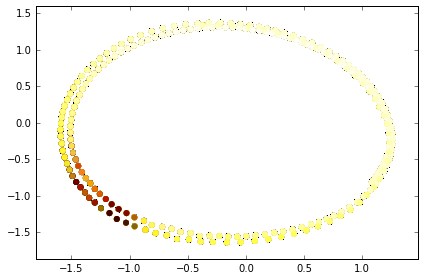

In [8]:
m.plot(visible_dims=(0,1))

Extract latent X from the model:

In [9]:
X = m.X
print(X)

  index      |  GPLVM.latent_mean  |  constraints  |  priors
  [0 0]      |         1.08184532  |               |        
  [0 1]      |        -0.81268260  |               |        
  [1 0]      |         1.09079541  |               |        
  [1 1]      |        -0.79506996  |               |        
  [2 0]      |         1.10760085  |               |        
  [2 1]      |        -0.76198783  |               |        
  [3 0]      |         1.12067423  |               |        
  [3 1]      |        -0.72995382  |               |        
  [4 0]      |         1.13507270  |               |        
  [4 1]      |        -0.69328813  |               |        
  [5 0]      |         1.14925504  |               |        
  [5 1]      |        -0.66152309  |               |        
  [6 0]      |         1.16423628  |               |        
  [6 1]      |        -0.62254529  |               |        
  [7 0]      |         1.17777487  |               |        
  [7 1]      |        -0

Plot first 5 values to visualize:

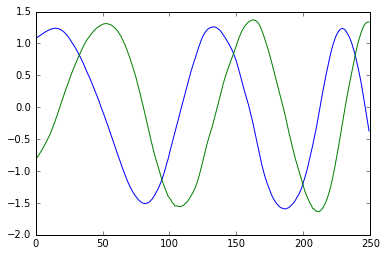

In [10]:
mp.plot(X[:,0:5])

Extract kernel matrix:

In [11]:
print(kernel)

  rbf.         |  value  |  constraints  |  priors
  variance     |    1.0  |      +ve      |        
  lengthscale  |   (2,)  |      +ve      |        


In [12]:
Kx = kernel.K(X[0:N-1])
print(Kx)

[[ 1.          0.99980486  0.99838465 ...,  0.06034355  0.04982028
   0.0414346 ]
 [ 0.99980486  1.          0.99931181 ...,  0.06202918  0.05117347
   0.0425187 ]
 [ 0.99838465  0.99931181  1.         ...,  0.06525517  0.05375894
   0.04458551]
 ..., 
 [ 0.06034355  0.06202918  0.06525517 ...,  1.          0.99162379
   0.96707829]
 [ 0.04982028  0.05117347  0.05375894 ...,  0.99162379  1.          0.99167275]
 [ 0.0414346   0.0425187   0.04458551 ...,  0.96707829  0.99167275  1.        ]]


Function to predict new artificial frame using mean prediction method:

In [13]:
def predict_new_latent_frame(N,X,kern,Kx_inv,X_old):
    
    k_x = kern.K(X[0:N-1],X_old)
    #k_xx = kern.K(X_old,X_old)

    meann = np.matmul(np.matmul(np.transpose(X[1:N]),Kx_inv),k_x).flatten()
    #cov = (k_xx - np.matmul(np.matmul(np.transpose(k_x),Kx_inv),k_x)) * np.eye(Q)
    
    #R = np.random.multivariate_normal(meann,cov)
    R = meann
    
    return R

Perform prediciton of new X:

In [14]:
N_synt = 500
X_synt = np.zeros((N_synt,Q))
X_last = X[N-1:N]
Kx_inv = np.linalg.inv(Kx)

for i in range(N_synt):
    X_synt[i,:] = predict_new_latent_frame(N,X,kernel,Kx_inv,X_last.reshape(1,Q))
    X_last = X_synt[i,:]
    
print(X_synt)

[[  8.25593550e+10   2.62956822e+11]
 [  0.00000000e+00   0.00000000e+00]
 [  1.04775335e+11   7.28733188e+10]
 [  0.00000000e+00   0.00000000e+00]
 [  1.04775335e+11   7.28733188e+10]
 [  0.00000000e+00   0.00000000e+00]
 [  1.04775335e+11   7.28733188e+10]
 [  0.00000000e+00   0.00000000e+00]
 [  1.04775335e+11   7.28733188e+10]
 [  0.00000000e+00   0.00000000e+00]
 [  1.04775335e+11   7.28733188e+10]
 [  0.00000000e+00   0.00000000e+00]
 [  1.04775335e+11   7.28733188e+10]
 [  0.00000000e+00   0.00000000e+00]
 [  1.04775335e+11   7.28733188e+10]
 [  0.00000000e+00   0.00000000e+00]
 [  1.04775335e+11   7.28733188e+10]
 [  0.00000000e+00   0.00000000e+00]
 [  1.04775335e+11   7.28733188e+10]
 [  0.00000000e+00   0.00000000e+00]
 [  1.04775335e+11   7.28733188e+10]
 [  0.00000000e+00   0.00000000e+00]
 [  1.04775335e+11   7.28733188e+10]
 [  0.00000000e+00   0.00000000e+00]
 [  1.04775335e+11   7.28733188e+10]
 [  0.00000000e+00   0.00000000e+00]
 [  1.04775335e+11   7.28733188e+10]
 

Plot of new X:

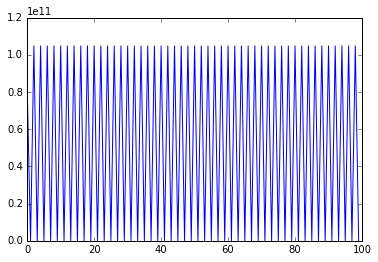

In [22]:
mp.plot(X_synt[0:100,0:1])
#mp.plot(X[:,0:2])

Now perform syntesis of the dinamic texture based on new X by using multivariate Gaussian:

In [16]:
Y_synt = np.zeros((N_synt,D))

Ky = kernel.K(X)
Ky_inv = np.linalg.inv(Ky)
Y_t = np.transpose(sample_norm)
k_y = kernel.K(X,X_synt)
k_yy = kernel.K(X_synt,X_synt)

meann = np.matmul(np.matmul(Y_t,Ky_inv),k_y)
cov = (k_yy - np.matmul(np.matmul(np.transpose(k_y),Ky_inv),k_y))


for i in range(D):
    Y_synt[:,i] = np.matmul(cov,np.random.randn(N_synt)) + meann[i,:]

print(Y_synt)

[[  1.06279101e+00  -4.65100742e-02  -5.65832427e-01 ...,   1.51408864e+00
   -1.11964144e+00   7.62470364e-01]
 [  3.13698261e+12   3.42258703e+12   3.65315637e+12 ...,   9.60704919e+11
    1.93500252e+12  -5.91384881e+11]
 [ -1.53165164e+01   7.28943383e+00  -2.07073097e+01 ...,   1.88354900e+01
   -1.36257705e+01  -6.68914697e+00]
 ..., 
 [  3.13698261e+12   3.42258703e+12   3.65315637e+12 ...,   9.60704919e+11
    1.93500252e+12  -5.91384881e+11]
 [ -1.53165164e+01   7.28943383e+00  -2.07073097e+01 ...,   1.88354900e+01
   -1.36257705e+01  -6.68914697e+00]
 [  3.13698261e+12   3.42258703e+12   3.65315637e+12 ...,   9.60704919e+11
    1.93500252e+12  -5.91384881e+11]]


Display first frame:

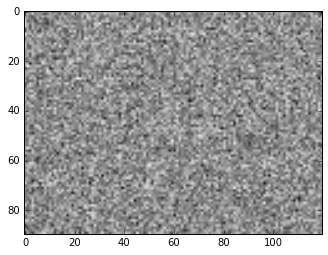

In [17]:
show_frame(Y_synt[0,:])

Denormalization using sample mean and standard deviation:

In [ ]:
Y_synt_denorm = sample_std * Y_synt + sample_mean

Finally, save normalized video. Just to make it more beautiful in visualization perform additional normalization independently for every frame:

In [ ]:
cap = cv2.VideoCapture(0)
fourcc = cv2.VideoWriter_fourcc(*'DIB ')
out = cv2.VideoWriter('data\output.avi',fourcc, 25.0, (w,h))

for i in range(N_synt):
    print(i)
    frame = Y_synt_denorm[i,:].reshape((h,w)).astype(int)
    max = frame.max()
    min = frame.min()
    frame = (255/(max - min))*(frame - min)    
    img = np.zeros((90,120,3), np.uint8)
    img[:,:,0] = frame
    img[:,:,1] = frame
    img[:,:,2] = frame
    out.write(img)

cap.release()
out.release()
cv2.destroyAllWindows()
print('Done!')